# Rain attenuation Prediction

**Abstract**
Liebe's MPM model concludes that excessive propagation loss is attribuate to point rainfall rates, for the frequencies above 20GHz, classifying it as a statistical problem. In this notebook we will create a regression model on the data and will try to predict the attenuation.

**About the Data** 
The data we took has three colums: *Time*, *Point Rainfall Rate* and *Attenuation*. The data is recorded for a day and is ordered. Thus we will try to create further one more column(using time): *daynight* {0: night, 1: Day}

*Test set* : 30% of the data
*Training set* : 60% of data
*Validation set*: 10% of data
**TARGET VAR : ***Attenuation*** **

## Hypothesis

1. *Rainfall Rate*: increase in the point rainfall rate will show positive effect on attenuation.

2. *Time of day*: during day hours, the convective effect can cause rainfall hence increasing attenuation.

## 1. Problem Statement
Forecasting attenuation (propagation loss) in signals as a function of point rainfall rate.

In [1]:
# importing libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sn 
from scipy.stats import ttest_ind
from datetime import datetime
from datetime import date
%matplotlib inline

In [2]:
#Reading Data
# File Name Here --------------------
filename = "data_06.csv"
# 
# Loading as dataframe
data = pd.read_csv(filename)
print ('(Rows, Columns):', data.shape)
data.head()

(Rows, Columns): (99304, 3)


,Time,Rain_rate,Attenuation
0,01:55:12,0.0997,0.927
1,01:55:12,0.0995,0.925
2,01:55:12,0.0994,0.914
3,01:55:12,0.0994,0.988
4,01:55:12,0.0990,0.981


In [3]:
# Creating extra columns for day and night
#
daynight = []
for i in range(0, data.shape[0]):
    # extracting hour
    t = data.iloc[i]["Time"]
    t = int(t.split(":")[0]) # HH:MM:SS
    if t in range(5, 18):
        daynight.append(1)
    else:
        daynight.append(0)
data["daynight"] = daynight
data.head()

,Time,Rain_rate,Attenuation,daynight
0,01:55:12,0.0997,0.927,0
1,01:55:12,0.0995,0.925,0
2,01:55:12,0.0994,0.914,0
3,01:55:12,0.0994,0.988,0
4,01:55:12,0.0990,0.981,0


In [4]:
#Preparing train, test, validation sets
#
# duplicating data
data_copy = data.copy()
# train : 60% of data
train = data.sample(frac = 0.6)
# remove selected rows from original data
data.drop(train.index, inplace = True)
#
# 
# validate : 10% of data
validate = data.sample(frac = 0.1)
# remove selected rows from orginial data
data.drop(validate.index, inplace = True)
#
#
# test : remainging 30% of data
test = data
#
#
# Restoring orginal data
data = data_copy
#
# Displaying result
print ("ROW COUNT")
print ("Train   \t", train.shape[0])
print ("Test    \t", test.shape[0])
print ("Validate\t", validate.shape[0])
print ("-------------------------")
print ("Total   \t", sum([train.shape[0], test.shape[0], validate.shape[0]]))
print ("-------------------------")
print ("Originally \t", data.shape[0])

ROW COUNT
Train   	 59582
Test    	 35750
Validate	 3972
-------------------------
Total   	 99304
-------------------------
Originally 	 99304


## 3. Data Exploration

### A. Variable Identification

In [5]:
# Identification of datatypes
#
# 
data.dtypes

Time            object
Rain_rate      float64
Attenuation    float64
daynight         int64
dtype: object

with the above data retrieved and provided information on variables we infer the following classification of variables:

categorical | | continuous
:--- | :---: | :---
daynight | | Rain_rate
 | | Attenuation *(target variable)*


variable | categories
---: | :---
daynight | {1:night, 0:day}

### B. Univariate Analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x062FAA90>,
      dtype=object)

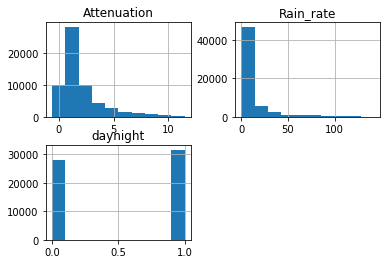

In [6]:
train.hist()

In [7]:
train.median() - train.mean()

Rain_rate     -8.726699
Attenuation   -0.681896
daynight       0.469404
dtype: float64

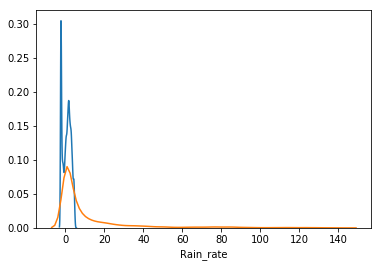

In [8]:
sn.distplot(np.log(train["Rain_rate"]), hist=False)
sn.distplot(train["Rain_rate"], hist=False)

while the log graph(*blue*) of "Rain_rate" shows deviation from bell-shaped curve, so we will continue to train data on the unmodified value(*orange*) of the same. As for the reason of it being right skewed can be due to presence of outliers (*removed later*)

#### Search of Missing Values

In [9]:
train.shape

(59582, 4)

In [10]:
train.describe()

,Rain_rate,Attenuation,daynight
count,59582.000000,59582.000000,59582.000000
mean,11.406699,1.991896,0.530596
std,21.359810,1.920623,0.499067
min,0.098000,-0.618000,0.000000
25%,0.271250,0.769000,0.000000
50%,2.680000,1.310000,1.000000
75%,11.200000,2.370000,1.000000
max,142.000000,11.500000,1.000000


In [11]:
train.isnull().sum()

Time           0
Rain_rate      0
Attenuation    0
daynight       0
dtype: int64

no missing values

#### Anamolies(Outliers) detection
##### for continuous vars

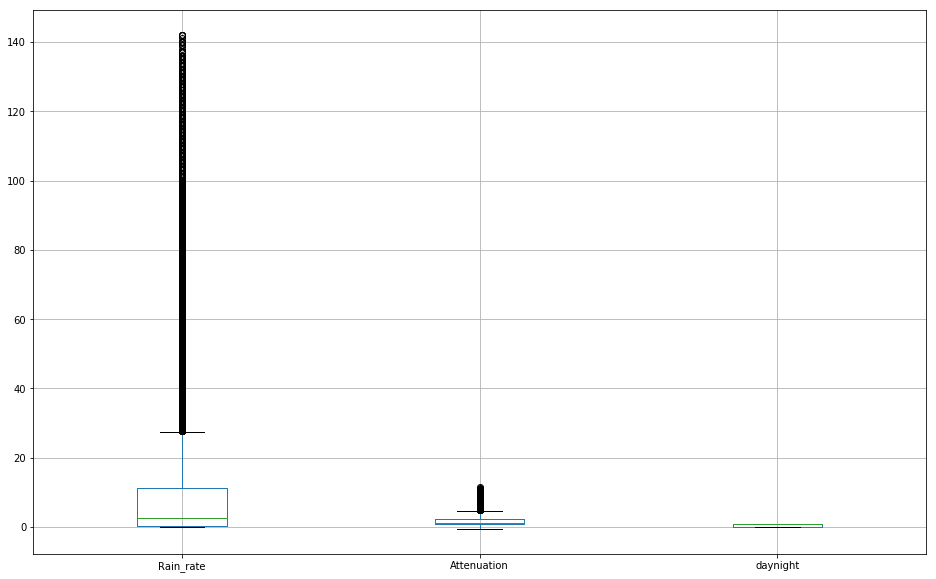

In [12]:
plt.figure(figsize=(16, 10))
train.boxplot()

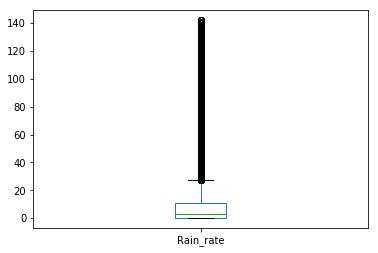

In [13]:
train['Rain_rate'].plot.box()

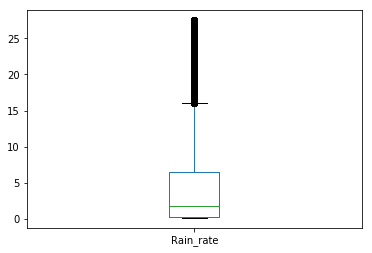

In [14]:
# Removing outlier(the black circles/thick vertical line) from above data
colname = "Rain_rate"
q1 = train[colname].quantile(0.25)
q3 = train[colname].quantile(0.75)
IQR = q3 - q1
train = train[ train[colname] >= (q1 - 1.5*IQR)]
train = train[ train[colname] <= (q3 + 1.5*IQR)]
train['Rain_rate'].plot.box()

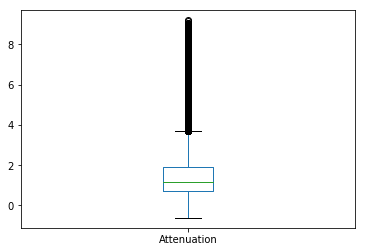

In [15]:
# detected in variable age_in_days
train['Attenuation'].plot.box()

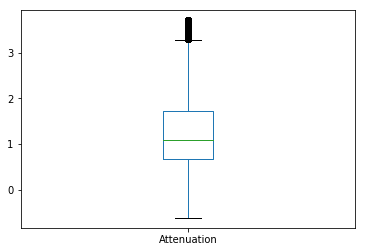

In [16]:
# Removing outlier(the black circles/thick vertical line) from above data
colname = "Attenuation"
q1 = train[colname].quantile(0.25)
q3 = train[colname].quantile(0.75)
IQR = q3 - q1
train = train[ train[colname] >= (q1 - 1.5*IQR)]
train = train[ train[colname] <= (q3 + 1.5*IQR)]
train[colname].plot.box()

#### Univariate Analysis of categorical vars

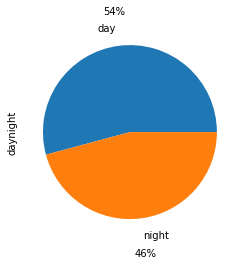

In [17]:
train['daynight'].value_counts().plot.pie(labels =['day','night'],autopct='%1.0f%%', pctdistance=1.4, labeldistance=1.2)

the above bar plot shows that we have approximately equal data about the categorical column *daynight* hence it model will not suffer from biasing

### C. Bivariate Analysis

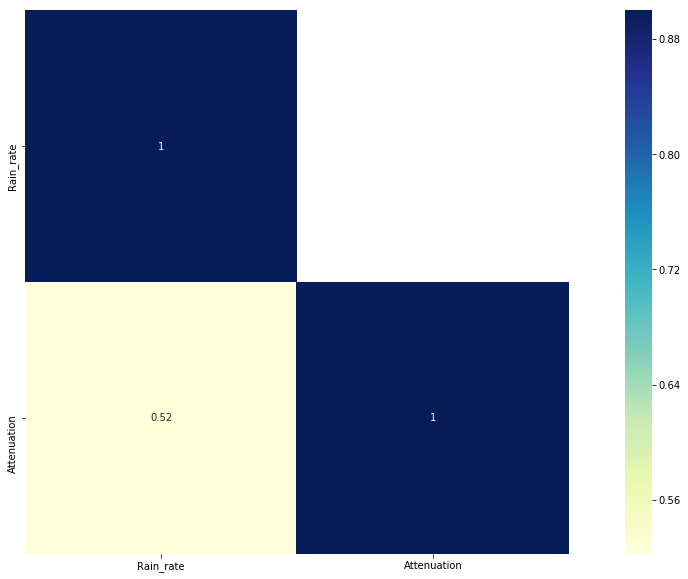

In [18]:
# looking at the correlation between numerical variables
corr = train[["Rain_rate", "Attenuation"]].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corr, mask=mask,vmax=.9, square=True,annot=True, cmap="YlGnBu")

Some of the inferences from the above correlation map are:

1. point rate has r > 0.05(the significance level) and is positive, thus our **hypothesis 1 holds true**, i.e with increase in rainfall_rate the attenuation shows similar effect.

To answer the **hypothesis 2 : time-of-day** we perform the categorical-continuous bivariate 2-samp-ttest

In [19]:
train['daynight'].value_counts()

1    26512
0    22415
Name: daynight, dtype: int64

In [20]:
day = train[train['daynight'] == 1]
night = train[train['daynight'] == 0]

In [21]:
ttest_ind(day['Attenuation'], night['Attenuation'], nan_policy='omit')

Ttest_indResult(statistic=11.446797009325135, pvalue=2.6668144295034523e-30)

since p < 0.05 we infer that the two samples of day and night are significantly indifferent, hence the variable does not divide the dataset for further analysis thereby is meaningless.

In [22]:
# Droping the useless daynigth column along with Time column which does note contribute special to the attenuation
#  and this we confirmed above using correlation and 2-sample ttest
#
train.drop(columns=['Time', 'daynight'], inplace=True)
validate.drop(columns=['Time', 'daynight'], inplace=True)
train.head()

,Rain_rate,Attenuation
69336,2.4900,1.30
67756,0.1040,1.76
20171,2.0000,1.03
3908,0.0991,0.58
21448,0.1840,3.10


## Model Building
### Linear Regression Model 
*since our target variable* (**count**) *is continuous.*

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [24]:
# initialize the linear regression model
lModel = LinearRegression()

We will remove the target variable from both the training and validation set and keep it in a separate variable.

In [25]:
target = "Attenuation"
X_train = train.drop(target,axis=1)
y_train = train[target]
X_val = validate.drop(target,axis=1)
y_val = validate[target]

In [26]:
# checking the shape of X_train, y_train, X_val and y_val
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((48927, 1), (48927,), (3972, 1), (3972,))

In [27]:
# fitting the model on X_train and y_train
lModel.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [28]:
# making prediction on validation set
prediction = lModel.predict(X_val)

In [30]:
mean_squared_error(y_val,prediction)

1.6831116681274674

We got a rmsle value of 1.72 >> 0 on the validation set.

Let's use Decision Tree (*later below*). Note that rmsle tells us how far the predictions are from the actual value, so we want rmsle value to be as close to 0 as possible. So, we will further try to reduce this value.

In [32]:
# Modifying the test set
#
test = test["Rain_rate"].copy()
#
# To predict values of our own data uncomment the below line
# test = pd.read_csv("your_file_containing_Rain_rate.csv")
test = pd.DataFrame(test)

KeyError: 'Rain_rate'

In [34]:
test.shape

(35750, 1)

In [35]:
# Making prediction
test_prediction = lModel.predict(test)

In [36]:
test_prediction

array([0.9751372 , 0.9751372 , 0.97510768, ..., 0.97518147, 0.97516671,
       0.97517409])

In [37]:
# Saving to file
np.savetxt("predict.csv", test_prediction, delimiter=",")

# Decision Tree

In [38]:
from sklearn.tree import DecisionTreeRegressor

In [39]:
# defining a decision tree model with a depth of 8. You can further tune the hyperparameters to improve the score
dt_reg = DecisionTreeRegressor(max_depth=5)

In [40]:
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [41]:
predict = dt_reg.predict(X_val)

In [42]:
# calculating rmsle of the predicted values
rmsle(y_val, predict)

1.6885136819475346

In [43]:
test_prediction = dt_reg.predict(test)

In [44]:
final_prediction = np.exp(test_prediction)

In [45]:
submission = pd.DataFrame()

In [46]:
# creating a count column and saving the predictions in it
submission['Attenuation'] = final_prediction

In [47]:
submission.to_csv('predict_decisionRegress.csv', header=True, index=False)

# Conclusion
The rmsle score > 1 for our model, hence this model both (linear regressor & decision tree regressor) cannot be considered suitable for prediction of attenuation caused by rainfall rate. Consider the research work of MPM, our model lacks data about moist air parameter (P, T, U) which can possibly help create a more improvised model.